## Preprocessing Data

In this part, we preprocess data images from different slides and their masks. Given a specific zoom level and a patch size, we will zoom in the slide/mask according to the zoom level and then divide it into patches with desired size. Then, patches without tissues will be removed. Finally, if the patch has a tumor, we save it to a tumor folder. If not, it will be saved to the no_tumor folder. 

In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
%matplotlib inline
import cv2
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [ ]:
# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [ ]:
#Find tissue 
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

In [ ]:
#Highlight tissue by coloring it red
def apply_mask(im, mask, color=(255,0,0)):
    masked = np.zeros((im.shape[0],im.shape[1],im.shape[2]))
    for x,y in mask: masked[x][y] = color
    return masked

In [ ]:
def preprocessing(slide_path,tumor_mask_path,patch_pixel,zoom_level):

  #Create different folders
  colab_root = '/content/'
  tumor_f = os.path.join(colab_root,'tumor/')
  no_tumor_f = os.path.join(colab_root,'no_tumor/')
  tumor_mask_f = os.path.join(colab_root,'tumor_mask/') 
  no_tumor_mask_f = os.path.join(colab_root,'no_tumor_mask/') 
  if os.path.exists(tumor_f) or os.path.exists(no_tumor_f) or os.path.exists(no_tumor_mask_f) or os.path.exists(tumor_mask_f):
    print("Some folders already exist")
  else:
    os.mkdir(tumor_f)
    os.mkdir(no_tumor_f)
    os.mkdir(tumor_mask_f)
    os.mkdir(no_tumor_mask_f) 

  #get image file name from specific slide path for future use
  imagename = slide_path.split('.')[0].strip()

  #open slide
  slide = open_slide(slide_path)
  tumor_mask = open_slide(tumor_mask_path)

  #get slide's size
  slide_width = slide.level_dimensions[zoom_level][0]
  slide_height = slide.level_dimensions[zoom_level][1]
  print('Slide path: '+ slide_path +' Slide Width:',slide_width, ' Slide height:', slide_height)

  #read entire slide and mask at given zoom level
  slide = read_slide(slide, x=0, y=0, level=zoom_level, width=slide_width,height=slide_height)
  tumor_mask = read_slide(tumor_mask, x=0, y=0, level=zoom_level, width=slide_width,height=slide_height)

  # Note: the program provided by the dataset authors generates a mask with R,G,B channels.
  # The mask info we need is in the first channel only.
  tumor_mask = tumor_mask[:,:,0]

  # Improve efficiency by ignoring non-tissue areas of the slide.
  # We'll find these by looking for all red regions.
  tissue_pixels = find_tissue_pixels(slide)
  tissue_regions = apply_mask(slide, tissue_pixels)

  #Now we need to divide patches into corresponding folders
  #First, given size of patch, get the number of patches
  x,y = slide.shape[0], slide.shape[1]
  num_xaxis, num_yaxis = int(np.ceil(x/patch_pixel)), int(np.ceil(y/patch_pixel))
  print('Total number of pathches for this slide (including non-tissue region):', 
        int(num_xaxis*num_yaxis))

  #Count tumor/ no tumor patch
  count_t = 0
  count_no_t = 0

  #Go through every patch and find whether tumors exist
  for i in range(num_xaxis):
    for j in range(num_yaxis):
      #Find patch's x,y corrdinates
      #There are also some patches whose pixels < patch_pixel as we cannot divide slide evenly
      if i == num_xaxis -1:
        slide_x_end = x
        patch_x_end = x-(num_xaxis-1)*patch_pixel
      else:
        slide_x_end = (i+1)*patch_pixel
        patch_x_end = patch_pixel
 
      if j == num_yaxis -1:
        slide_y_end = y
        patch_y_end = y-(num_yaxis-1)*patch_pixel
      else:
        slide_y_end = (j+1)*patch_pixel
        patch_y_end = patch_pixel
      
      #Get patch and its mask from tissue region and check whether tissue exists
      #If not exist, not save the patch and its mask
      check_patch_tissue=np.zeros((patch_pixel,patch_pixel,3))
      patch_img = np.zeros((patch_pixel,patch_pixel,3))
      patch_mask_img = np.zeros((patch_pixel,patch_pixel))
      
      check_patch_tissue[0:patch_x_end,0:patch_y_end,:] = tissue_regions[i*patch_pixel:slide_x_end, j*patch_pixel:slide_y_end,:]

      if np.mean(check_patch_tissue) > float(0): # there is tissue
        #Get patch and its mask
        patch_img[0:patch_x_end,0:patch_y_end,:]=slide[i*patch_pixel:slide_x_end, j*patch_pixel:slide_y_end,:]
        patch_mask_img[0:patch_x_end,0:patch_y_end]=tumor_mask[i*patch_pixel:slide_x_end, j*patch_pixel:slide_y_end]

        #Check wether there is tumor inside the patch through its mask image      
        if np.mean(patch_mask_img)> float(0): #there is tumor
          count_t+=1
          patch_filename = tumor_f+str(imagename)+'_patch_'+str(i*num_yaxis+j)+'.jpg'
          patch_mask_filename = tumor_mask_f+str(imagename)+'_patch_'+str(i*num_yaxis+j)+'.jpg'

        else: #no tumor
          count_no_t+=1
          patch_filename = no_tumor_f+str(imagename)+'_patch_'+str(i*num_yaxis+j)+'.jpg'
          patch_mask_filename = no_tumor_mask_f+str(imagename)+'_patch_'+str(i*num_yaxis+j)+'.jpg'  

        #save patches with corresponding file name
        cv2.imwrite(patch_filename,patch_img)  
        cv2.imwrite(patch_mask_filename,patch_mask_img)  
  print('Number of tumor patches:',count_t,' Number of no tumor patches:',count_no_t)
  

### Load Data
The slides we randomly chose are 'tumor_091', 'tumor_101' and 'tumor_110'.

In [ ]:
# Download example slides and tumor masks

slide_path1 = 'tumor_091.tif' 
tumor_mask_path1 = 'tumor_091_mask.tif' 

slide_url1 = 'https://storage.googleapis.com/applied-dl/%s' % slide_path1
mask_url1 = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path1

# Download the whole slide image
if not os.path.exists(slide_path1):
  !curl -O $slide_url1

# Download the tumor mask
if not os.path.exists(tumor_mask_path1):
  !curl -O $mask_url1


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  521M  100  521M    0     0  28.2M      0  0:00:18  0:00:18 --:--:-- 29.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.6M  100 14.6M    0     0  13.8M      0  0:00:01  0:00:01 --:--:-- 13.8M


In [ ]:
# second slide
slide_path2 = 'tumor_110.tif' 
tumor_mask_path2 = 'tumor_110_mask.tif' 

slide_url2 = 'https://storage.googleapis.com/adl_final4955/%s' % slide_path2
mask_url2 = 'https://storage.googleapis.com/adl_final4955/%s' % tumor_mask_path2

if not os.path.exists(slide_path2):
  !curl -O $slide_url2

if not os.path.exists(tumor_mask_path2):
  !curl -O $mask_url2


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1416M  100 1416M    0     0   117M      0  0:00:12  0:00:12 --:--:-- 97.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31.3M  100 31.3M    0     0  78.1M      0 --:--:-- --:--:-- --:--:-- 78.1M


In [ ]:
# third slide
slide_path3 = 'tumor_101.tif' 
tumor_mask_path3 = 'tumor_101_mask.tif' 

slide_url3 = 'https://storage.googleapis.com/adl_final4955/%s' % slide_path3
mask_url3 = 'https://storage.googleapis.com/adl_final4955/%s' % tumor_mask_path3

if not os.path.exists(slide_path3):
  !curl -O $slide_url3

if not os.path.exists(tumor_mask_path3):
  !curl -O $mask_url3


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1392M  100 1392M    0     0  40.6M      0  0:00:34  0:00:34 --:--:-- 32.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 43.9M  100 43.9M    0     0  85.9M      0 --:--:-- --:--:-- --:--:-- 85.7M


In order to fit model well, we choose an patch size 299*299. 

In [ ]:
preprocessing(slide_path1,tumor_mask_path1,299,3)

Slide path: tumor_091.tif Slide Width: 7680  Slide height: 6720
Total number of pathches for this slide (including non-tissue region): 598
Number of tumor patches: 27  Number of no tumor patches: 561


In [ ]:
preprocessing(slide_path2,tumor_mask_path2,299,3)

Some folders already exist
Slide path: tumor_110.tif Slide Width: 11776  Slide height: 8960
Total number of pathches for this slide (including non-tissue region): 1200
Number of tumor patches: 275  Number of no tumor patches: 841


In [ ]:
preprocessing(slide_path3,tumor_mask_path3,299,3)

Some folders already exist
Slide path: tumor_101.tif Slide Width: 17408  Slide height: 8960
Total number of pathches for this slide (including non-tissue region): 1770
Number of tumor patches: 82  Number of no tumor patches: 1634


In [ ]:
no_tumor_f_len = len(os.listdir('/content/no_tumor'))
tumor_f_len = len(os.listdir('/content/tumor'))
print('Patch without tumor:', no_tumor_f_len,' Patch with tumor:',tumor_f_len)

Patch without tumor: 3036  Patch with tumor: 384


### Sanity Check


Tumor and Mask


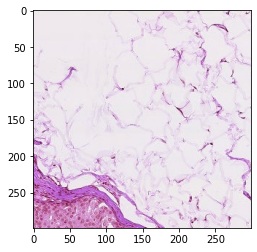

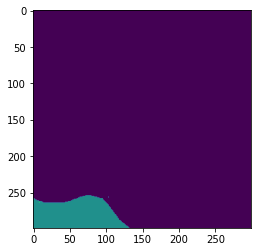

No Tumor and Mask


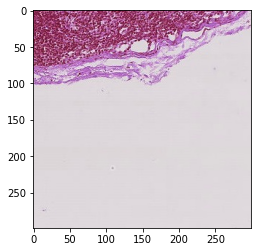

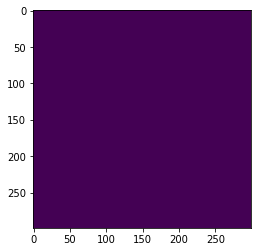

In [ ]:
# print some examples of patch and mask
tumor_img = os.listdir('/content/tumor')
no_tumor_img = os.listdir('/content/no_tumor')

print('Tumor and Mask')
img_path = os.path.join('/content/tumor',tumor_img[9])
mask_path = os.path.join('/content/tumor_mask',tumor_img[9])
plt.imshow(io.imread(img_path))
plt.show()
plt.imshow(io.imread(mask_path))
plt.show()

print('No Tumor and Mask')
img_path = os.path.join('/content/no_tumor',no_tumor_img[30])
mask_path = os.path.join('/content/no_tumor_mask',no_tumor_img[30])
plt.imshow(io.imread(img_path))
plt.show()
plt.imshow(io.imread(mask_path))
plt.show()

### Create Training and Validation Sets

We can see the result above that the number of patches without tumor is quite larger than that of patches with tumor. This will result an very imbalanced dataset. Hence, we have decided to create a balanced dataset with all tumor patches we have and no tumor patches with similar size. Notice, the size of the dataset will not be large since we have a small number of tumor patches. This may have some impacts on validation accuracy later since we do not have much data to train.


When creating training, validation and test sets, we follow a ratio of 4:1:1.

In [ ]:
#Create train, val and test directory
train_f = '/content/train'
val_f = '/content/val'
test_f = '/content/test'

os.mkdir(train_f)
os.mkdir(val_f)
os.mkdir(test_f)


train_tumor = os.path.join(train_f,'tumor')
train_no_tumor = os.path.join(train_f,'no_tumor')
os.mkdir(train_tumor)
os.mkdir(train_no_tumor)

val_tumor = os.path.join(val_f,'tumor')
val_no_tumor = os.path.join(val_f,'no_tumor')
os.mkdir(val_tumor)
os.mkdir(val_no_tumor)

test_tumor = os.path.join(test_f,'tumor')
test_no_tumor = os.path.join(test_f,'no_tumor')
os.mkdir(test_tumor)
os.mkdir(test_no_tumor)



In [ ]:
#shuffle tumor and no_tumor folders
import random
tumor_img = os.listdir('/content/tumor')
no_tumor_img = os.listdir('/content/no_tumor')
random.shuffle(tumor_img)
random.shuffle(no_tumor_img)
print(len(tumor_img))
print(len(no_tumor_img))

tumor_len =len(tumor_img)
no_tumor_len = len(no_tumor_img)

384
3036


As we only have 384 patches with tumor, we will use 384 patches without tumor to keep balance. We divide those tumor patches and no-tumor pathces into training, validation and testing ratio of 4:1:1, and put them into respective folders. 

In [ ]:
import shutil

#Training-Tumor
for im in tumor_img[0:int(tumor_len*4/6)]:
  shutil.copy(os.path.join('/content/tumor',im),train_tumor)
print('Training with Tumor:',len(os.listdir(train_tumor)))

#Validation-Tumor
for im in tumor_img[int(tumor_len*4/6):int(tumor_len*5/6)]:
  shutil.copy(os.path.join('/content/tumor',im),val_tumor)
print('Validation with Tumor:',len(os.listdir(val_tumor)))

# Test-Tumor
for im in tumor_img[int(tumor_len*5/6):]:
  shutil.copy(os.path.join('/content/tumor',im),test_tumor)
print('Test with Tumor:',len(os.listdir(test_tumor)))


#Training-NoTumor
for im in no_tumor_img[0:int(tumor_len*4/6)]:
  shutil.copy(os.path.join('/content/no_tumor',im),train_no_tumor)
print('Training without Tumor:',len(os.listdir(train_no_tumor)))

#Validation-NoTumor
for im in no_tumor_img[int(tumor_len*4/6):int(tumor_len*5/6)]:
  shutil.copy(os.path.join('/content/no_tumor',im),val_no_tumor)
print('Validation without Tumor:',len(os.listdir(val_no_tumor)))

#Test-NoTumor
for im in no_tumor_img[int(tumor_len*5/6):384]:
  shutil.copy(os.path.join('/content/no_tumor',im),test_no_tumor)
print('Test with Tumor:',len(os.listdir(test_no_tumor)))


Training with Tumor: 256
Validation with Tumor: 64
Test with Tumor: 64
Training without Tumor: 256
Validation without Tumor: 64
Test with Tumor: 64


In [ ]:
# Create training, validation and test database
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory( # train_f is the parent folder，and flow_from_directory will read all photos under this folder 
        train_f, # a path as string 
        target_size=(299,299), 
        class_mode='binary',
        batch_size=32)

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)  
    break

Found 512 images belonging to 2 classes.
data batch shape: (32, 299, 299, 3)
labels batch shape: (32,)


In [ ]:
validation_generator = validation_datagen.flow_from_directory(
        val_f,
        target_size=(299,299),
        class_mode='binary',
        batch_size=32) 

test_generator = test_datagen.flow_from_directory(
        test_f,
        target_size=(299,299),
        class_mode='binary',
        batch_size=32) 

Found 128 images belonging to 2 classes.
Found 128 images belonging to 2 classes.


## Training Model
First, we use InceptionV3 as our base model to do transfer learning on top of. 

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(299,299, 3)
)

base_model.trainable = False 

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid') # Add a binary classifier layer on top

# build a new model reusing the pretrained base and adding two layers on top of the convolutional base 
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit( 
      train_generator,
      epochs=5,
      validation_data=validation_generator)

Epoch 1/5
16/16 [==============================] - 45s 483ms/step - loss: 0.5893 - accuracy: 0.6681 - val_loss: 0.2739 - val_accuracy: 0.9219
Epoch 2/5
16/16 [==============================] - 6s 349ms/step - loss: 0.3462 - accuracy: 0.8489 - val_loss: 0.2126 - val_accuracy: 0.9141
Epoch 3/5
16/16 [==============================] - 6s 354ms/step - loss: 0.2518 - accuracy: 0.8939 - val_loss: 0.1842 - val_accuracy: 0.9297
Epoch 4/5
16/16 [==============================] - 6s 352ms/step - loss: 0.2183 - accuracy: 0.9051 - val_loss: 0.1936 - val_accuracy: 0.9375
Epoch 5/5
16/16 [==============================] - 6s 353ms/step - loss: 0.2219 - accuracy: 0.8825 - val_loss: 0.1625 - val_accuracy: 0.9297


Evaluate on Test Set

In [ ]:
loss, acc = model.evaluate(test_generator)
print("Testing loss is",round(loss,3), "and testing accuracy is",round(acc,3))

4/4 [==============================] - 1s 272ms/step - loss: 0.2368 - accuracy: 0.8750
Testing loss is 0.237 and testing accuracy is 0.875


Confusion Matrix

In [ ]:
# Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix 
y_pred = model.predict(test_generator)
y_binary_predict = np.array([1.0 if item>0.9*np.max(y_pred) else 0.0 for item in y_pred])

print("Confusion matrix is:")
print(confusion_matrix(test_generator.classes,y_binary_predict))

print("Classification report is: ")
print(classification_report(test_generator.classes,y_binary_predict))

Confusion matrix is:
[[42 22]
 [46 18]]
Classification report is: 
              precision    recall  f1-score   support

           0       0.48      0.66      0.55        64
           1       0.45      0.28      0.35        64

    accuracy                           0.47       128
   macro avg       0.46      0.47      0.45       128
weighted avg       0.46      0.47      0.45       128



Predict on a New Slide


We then use a new slide 'tumor_075.tif' to test our model.

In [ ]:
# Download testing slides and tumor masks for tumor_075.tif 

slide_path4 = 'tumor_075.tif' 
tumor_mask_path4 = 'tumor_075_mask.tif' 

slide_url4 = 'https://storage.googleapis.com/adl_final4955/%s' % slide_path4
mask_url4 = 'https://storage.googleapis.com/adl_final4955/%s' % tumor_mask_path4


# Download the whole slide image
if not os.path.exists(slide_path4):
  !curl -O $slide_url4

# Download the tumor mask
if not os.path.exists(tumor_mask_path4):
  !curl -O $mask_url4

In [ ]:
  # open slide
  slide = open_slide(slide_path4)
  tumor_mask = open_slide(tumor_mask_path4)

  zoom_level =3

  # get slide's size
  slide_width = slide.level_dimensions[zoom_level][0]
  slide_height = slide.level_dimensions[zoom_level][1]
  print('Slide path: '+ slide_path4 +' Slide Width:',slide_width, ' Slide height:', slide_height)

  # read entire slide and mask at given zoom level
  test_slide = read_slide(slide, x=0, y=0, level=zoom_level, width=slide_width,height=slide_height)
  test_tumor_mask = read_slide(tumor_mask, x=0, y=0, level=zoom_level, width=slide_width,height=slide_height)

  test_tumor_mask = test_tumor_mask[:,:,0]

Slide path: tumor_075.tif Slide Width: 11264  Slide height: 9856


In [ ]:

# Get predictions from the given slide using the above model
patch_pixel = 299

x,y = test_slide.shape[0], test_slide.shape[1]

num_xaxis, num_yaxis = int(np.ceil(x/patch_pixel)), int(np.ceil(y/patch_pixel))

print('Total number of pathches for this slide (including non-tissue region):', 
        int(num_xaxis*num_yaxis))

 
predictions = []

# Go through every patch to get its prediction
for i in range(num_xaxis):
  for j in range(num_yaxis):
      # Find patch's x,y corrdinates
      # There are also some patches whose pixels < patch_pixel as we cannot divide slide evenly

    if i == num_xaxis -1:
      slide_x_end = x 
      patch_x_end = x-(num_xaxis-1)*patch_pixel
    else:
      slide_x_end = (i+1)*patch_pixel
      patch_x_end = patch_pixel
 
    if j == num_yaxis -1:
      slide_y_end = y
      patch_y_end = y-(num_yaxis-1)*patch_pixel
    else:
      slide_y_end = (j+1)*patch_pixel
      patch_y_end = patch_pixel
      

    patch = np.zeros((patch_pixel,patch_pixel,3)) 
      
    patch[0:patch_x_end,0:patch_y_end,:]= test_slide[i*patch_pixel:slide_x_end, j*patch_pixel:slide_y_end,:]
    
    each_patch = np.array(patch[:,:,:]) /255.0

    each_patch = np.expand_dims(each_patch, axis=0) # add a dimenstion of 1 on the first axis of shape for model prediction  

    # print(each_patch.shape)

    predictions.extend(model.predict(each_patch)) 



Total number of pathches for this slide (including non-tissue region): 1254


In [ ]:
predict = np.array([1.0 if item>0.9*np.max(predictions) else 0.0 for item in predictions])

predict = predict.reshape((num_xaxis,num_yaxis))

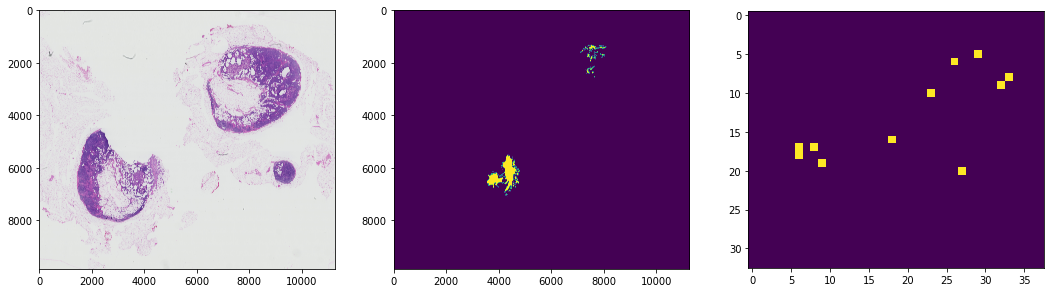

In [ ]:
plt.figure(figsize=(18,10))
plt.subplot(1,3,1)
plt.imshow(test_slide)
plt.subplot(1,3,2)
plt.imshow(test_tumor_mask)
plt.subplot(1,3,3)
plt.imshow(predict)
plt.show()

## Improve the Original Model 


Since the training set is so small, in order to prevent overfitting and increase validation accuracy, we add a data augmentation to the model and also add few layers. However, the quite small sizes of training and validation sets make it harder to significantly increase validation accuracy. Here, we just improve a little bit or roughly the same as the original model.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(299,299, 3)
)

base_model.trainable = False 

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid') # Add a binary classifier layer on top

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

# Add some layers to the original model 
model = tf.keras.Sequential([
  data_augmentation,
  base_model,
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(4, 3, activation='relu', input_shape=(299,299, 3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  prediction_layer
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit( 
      train_generator,
      epochs=5,
      validation_data=validation_generator)

Epoch 1/5
16/16 [==============================] - 15s 484ms/step - loss: 0.6641 - accuracy: 0.6427 - val_loss: 0.3481 - val_accuracy: 0.8984
Epoch 2/5
16/16 [==============================] - 6s 368ms/step - loss: 0.3687 - accuracy: 0.8479 - val_loss: 0.2027 - val_accuracy: 0.8984
Epoch 3/5
16/16 [==============================] - 6s 370ms/step - loss: 0.2527 - accuracy: 0.8745 - val_loss: 0.2197 - val_accuracy: 0.9141
Epoch 4/5
16/16 [==============================] - 6s 368ms/step - loss: 0.2469 - accuracy: 0.8712 - val_loss: 0.2072 - val_accuracy: 0.9219
Epoch 5/5
16/16 [==============================] - 6s 369ms/step - loss: 0.2266 - accuracy: 0.8946 - val_loss: 0.1768 - val_accuracy: 0.9531


Evaluate on Test Set

In [ ]:
loss, acc = model.evaluate(test_generator)
print("Testing loss is",round(loss,3), "and testing accuracy is",round(acc,3))

4/4 [==============================] - 1s 287ms/step - loss: 0.2187 - accuracy: 0.9062
Testing loss is 0.219 and testing accuracy is 0.906


Confusion Matrix

In [ ]:
# Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix 
y_pred = model.predict(test_generator)
y_binary_predict = np.array([1.0 if item>0.9*np.max(y_pred) else 0.0 for item in y_pred])

print("Confusion matrix is:")
print(confusion_matrix(test_generator.classes,y_binary_predict))

print("Classification report is: ")
print(classification_report(test_generator.classes,y_binary_predict))

Confusion matrix is:
[[36 28]
 [40 24]]
Classification report is: 
              precision    recall  f1-score   support

           0       0.47      0.56      0.51        64
           1       0.46      0.38      0.41        64

    accuracy                           0.47       128
   macro avg       0.47      0.47      0.46       128
weighted avg       0.47      0.47      0.46       128



Predict on a New Slide


We then use a new slide 'tumor_075.tif' to test our model.

In [ ]:
  # open slide
  slide = open_slide(slide_path4)
  tumor_mask = open_slide(tumor_mask_path4)

  zoom_level =3

  # get slide's size
  slide_width = slide.level_dimensions[zoom_level][0]
  slide_height = slide.level_dimensions[zoom_level][1]
  print('Slide path: '+ slide_path4 +' Slide Width:',slide_width, ' Slide height:', slide_height)

  # read entire slide and mask at given zoom level
  test_slide = read_slide(slide, x=0, y=0, level=zoom_level, width=slide_width,height=slide_height)
  test_tumor_mask = read_slide(tumor_mask, x=0, y=0, level=zoom_level, width=slide_width,height=slide_height)

  test_tumor_mask = test_tumor_mask[:,:,0]

Slide path: tumor_075.tif Slide Width: 11264  Slide height: 9856


In [ ]:

# Get predictions from the given slide using the above model
patch_pixel = 299

x,y = test_slide.shape[0], test_slide.shape[1]

num_xaxis, num_yaxis = int(np.ceil(x/patch_pixel)), int(np.ceil(y/patch_pixel))

print('Total number of pathches for this slide (including non-tissue region):', 
        int(num_xaxis*num_yaxis))

 
predictions = []

# Go through every patch to get its prediction
for i in range(num_xaxis):
  for j in range(num_yaxis):
      # Find patch's x,y corrdinates
      # There are also some patches whose pixels < patch_pixel as we cannot divide slide evenly

    if i == num_xaxis -1:
      slide_x_end = x 
      patch_x_end = x-(num_xaxis-1)*patch_pixel
    else:
      slide_x_end = (i+1)*patch_pixel
      patch_x_end = patch_pixel
 
    if j == num_yaxis -1:
      slide_y_end = y
      patch_y_end = y-(num_yaxis-1)*patch_pixel
    else:
      slide_y_end = (j+1)*patch_pixel
      patch_y_end = patch_pixel
      

    patch = np.zeros((patch_pixel,patch_pixel,3)) 
      
    patch[0:patch_x_end,0:patch_y_end,:]= test_slide[i*patch_pixel:slide_x_end, j*patch_pixel:slide_y_end,:]
    
    each_patch = np.array(patch[:,:,:]) /255.0

    each_patch = np.expand_dims(each_patch, axis=0) # add a dimenstion of 1 on the first axis of shape for model prediction  

    # print(each_patch.shape)

    predictions.extend(model.predict(each_patch)) 



Total number of pathches for this slide (including non-tissue region): 1254


In [ ]:
predict = np.array([1.0 if item>0.9*np.max(predictions) else 0.0 for item in predictions])

predict = predict.reshape((num_xaxis,num_yaxis))

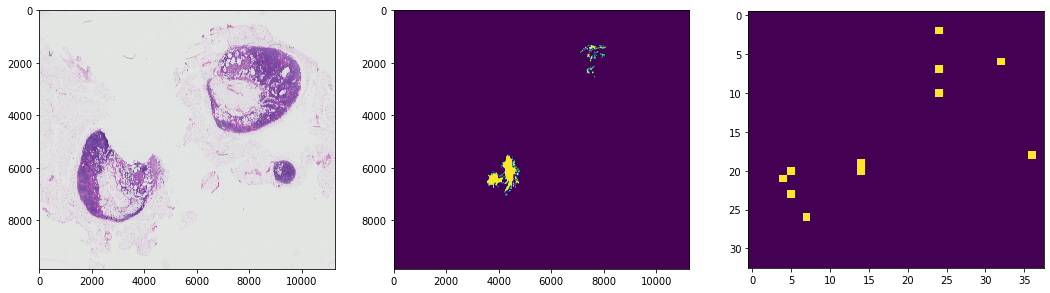

In [ ]:
plt.figure(figsize=(18,10))
plt.subplot(1,3,1)
plt.imshow(test_slide)
plt.subplot(1,3,2)
plt.imshow(test_tumor_mask)
plt.subplot(1,3,3)
plt.imshow(predict)
plt.show()